# Estimating causal effects using instrumental variables

## Overview

### **Task**: estimating causal effects in the presence of unobserved confounders and instruments

We know that causal effects are not identifiable in the presence of unobserved (latent) confounders.  However, they become identifiable if in addition one assumes the existence of so-called *instruments*. The instruments are observed (and usually controlled) variables which affect the outcome only through the treatment, and they are independent of the unobserved confounders.

Here we consider a simple linear Gaussian SCM (structural causal model), taken from Chapter 9.3 of Peters et al. *Elements of Causal Inference: Foundations and Learning Algorithms* (https://mitpress.mit.edu/books/elements-causal-inference).
\begin{align}
\begin{split}
X&:=\beta Z+\gamma H+N_X,\\
Y&:=\alpha X+\delta H+N_Y,\\
Z&\sim N(0,\sigma_Z),\;H\sim N(0,\sigma_H),\;N_X \sim N(0,\sigma_X), N_Y \sim N(0,\sigma_Y)\\
\alpha,\beta,\gamma,\delta&\sim N(0,10),\\
\sigma_Z,\sigma_H&\sim\text{Unif}(0,2),\;\sigma_X,\sigma_Y\sim\text{Unif}(0,10).
\end{split}
\end{align}

Here $Z$ is the instrument, $X$ is the treatment, $Y$ is the outcome, and $H$ is the unobserved confounder. Our goal is to estimate the coefficient $\alpha$.

### **Approach**

We generate some data, and then fit the posterior distribution over the model parameters by variational inference. We then use the counterfactual prediction to compute
$$
\hat{\alpha}=\mathbb{E}[Y|do(X=1)]-\mathbb{E}[Y|do(X=0)].
$$

## Setup

We start by importing the necessary modules. 

In [2]:
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from pyro.nn import PyroModule, PyroSample
from torch import nn
import torch
import pyro.distributions as dist
from chirho.observational.handlers import condition
from chirho.observational.handlers.predictive import PredictiveModel
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from pyro.infer.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
import functools
from chirho.robust.handlers.estimators import MonteCarloInfluenceEstimator, one_step_corrected_estimator 
from typing import Callable
from tqdm import tqdm

torch.set_default_device('cpu')
pyro.settings.set(module_local_params=True) # DO WE WANT TO LEAVE IT HERE>?

smoke_test = "CI" in os.environ

Next we define our generative model, both the unconstrained and the data-constrained version.

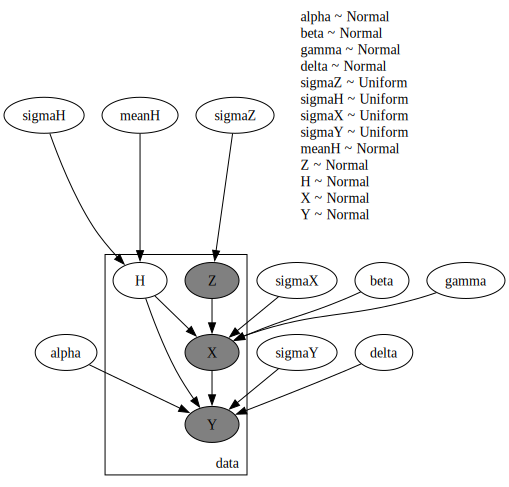

In [7]:
class BayesianLinearGaussianSCM(PyroModule):
    def __init__(self):
        super().__init__()

    @PyroSample
    def alpha(self):
        return dist.Normal(0,10)

    @PyroSample
    def beta(self):
        return dist.Normal(0, 10)
    
    @PyroSample
    def gamma(self):
        return dist.Normal(0, 10)
    
    @PyroSample
    def delta(self):
        return dist.Normal(0, 10)
    
    @PyroSample
    def sigmaZ(self):
        return dist.Uniform(0,2)
    
    @PyroSample
    def sigmaH(self):
        return dist.Uniform(0,2)
    
    @PyroSample
    def sigmaX(self):
        return dist.Uniform(0,10)
    
    @PyroSample
    def sigmaY(self):
        return dist.Uniform(0,10)
    
    @PyroSample
    def meanH(self):
        return dist.Normal(0,2)
    
    def forward(self):
        Z = pyro.sample('Z',dist.Normal(0,self.sigmaZ))
        H = pyro.sample('H',dist.Normal(self.meanH, self.sigmaH))
        X = pyro.sample('X',dist.Normal(self.beta * Z + self.gamma * H, self.sigmaX))
        Y = pyro.sample('Y',dist.Normal(self.alpha * X + self.delta * H, self.sigmaY))
        return X,Y,Z
    
class ObservedBayesianLinearGaussianSCM(BayesianLinearGaussianSCM):
    def __init__(self, n : int):
        super().__init__()
        self.n = n

    def forward(self, X=None, Y=None, Z=None):
        self.alpha, self.beta, self.gamma, self.delta, self.sigmaZ, self.sigmaH, self.sigmaX, self.sigmaY, self.meanH
        with condition(data={'Z': Z, 'X' : X, 'Y': Y}):
            with pyro.plate("data", self.n, dim=-1):
                return super().forward()

pyro.render_model(ObservedBayesianLinearGaussianSCM(10),
                  (torch.rand(10),torch.rand(10),torch.rand(10)),
                  render_distributions=True,
                  render_params=True)

Now we choose particular values of the model parameters.

Notice that the values of the coefficients $\alpha,\beta,\gamma,\delta$ are approximately of the same order of magnitude. This ensures that the effect of $X\to Y$ is roughly of the same strength as the effect of the confounder on $X,Y$, which is a reasonably nontrivial setting for the problem at hand.

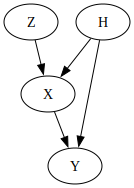

In [6]:
class GroundTruthModel(BayesianLinearGaussianSCM):
    def __init__(self, alpha, beta, gamma, delta, sigmaZ, sigmaH, sigmaX, sigmaY, meanH):
        super().__init__()
        self._alpha = alpha
        self._beta = beta
        self._gamma = gamma
        self._delta = delta
        self._sigmaZ = sigmaZ
        self._sigmaH = sigmaH
        self._sigmaX = sigmaX
        self._sigmaY = sigmaY
        self._meanH = meanH


    @property
    def alpha(self):
        return self._alpha
    
    @property
    def beta(self):
        return self._beta
    
    @property
    def gamma(self):
        return self._gamma
    
    @property
    def delta(self):
        return self._delta
    
    @property
    def sigmaZ(self):
        return self._sigmaZ
    
    @property
    def sigmaH(self):
        return self._sigmaH
    
    @property
    def sigmaX(self):
        return self._sigmaX
    
    @property
    def sigmaY(self):
        return self._sigmaY
    
    @property
    def meanH(self):
        return self._meanH
    

true_alpha, true_beta, true_gamma, true_delta = torch.tensor(1.5), torch.tensor(2.0), torch.tensor(1.3), torch.tensor(-1.2)
true_sigmaZ, true_sigmaH, true_sigmaX, true_sigmaY = torch.tensor(0.1), torch.tensor(0.1), torch.tensor(0.1), torch.tensor(0.1)
true_meanH = torch.tensor(0.00)

gt_model = GroundTruthModel(true_alpha, true_beta, true_gamma, true_delta, true_sigmaZ, true_sigmaH, true_sigmaX, true_sigmaY, true_meanH)

pyro.render_model(gt_model)